In [2]:
import requests
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import gamma
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from datetime import datetime, timedelta
from pprint import pprint
import collections

In [3]:
import c3aidatalake

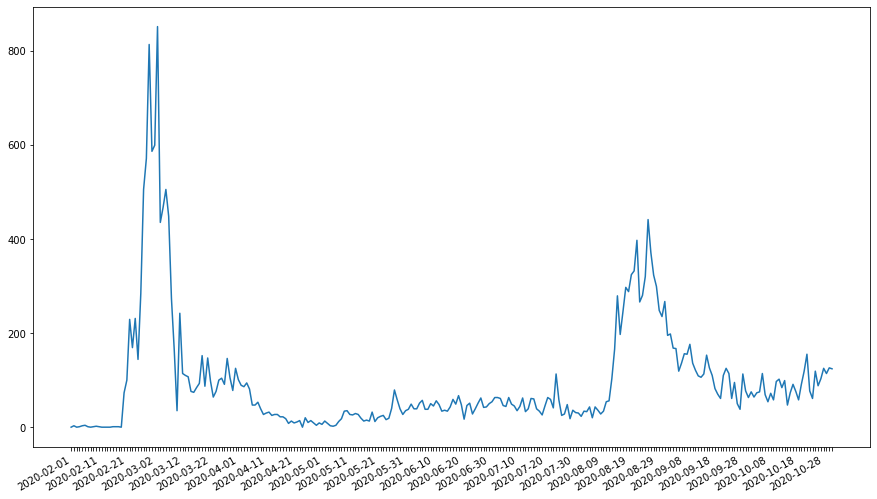

In [28]:
Confirmed_cases_Korea = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
      "spec": {
        "ids": ["KoreaSouth"],
        "expressions":["JHU_ConfirmedCases"],
        "interval":"DAY",
        "start":"2020-02-01",
        "end" : "2020-11-01"
      }
    }
)
Confirmed_cases_Korea['daily_increase_case'] = Confirmed_cases_Korea.diff()['KoreaSouth.JHU_ConfirmedCases.data']
Confirmed_cases_Korea["dates"] = Confirmed_cases_Korea["dates"].dt.date
dates_list = [date.strftime("%Y-%m-%d") for date in Confirmed_cases_Korea['dates'].tolist()]
daily_increased_df = pd.DataFrame(0, index=dates_list, columns=['daily_increase'])
for index, row in Confirmed_cases_Korea.iterrows():
    confirmed_date = row['dates'].strftime("%Y-%m-%d")
    daily_case = 0
    if (not pd.isna(row['daily_increase_case'])):
        daily_case = row['daily_increase_case']
    daily_increased_df.at[confirmed_date, 'daily_increase'] = daily_case
import matplotlib.dates as mdates
dates = daily_increased_df.index.tolist()

y_values = daily_increased_df['daily_increase'].tolist()


plt.rcParams['figure.figsize'] = [15, 9]
fig, ax = plt.subplots()
ax.plot(dates, y_values)


fig.autofmt_xdate()

ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.savefig('Fig1.png')
plt.show()


In [31]:
# Policy applied in korea
Policy_South_Korea = c3aidatalake.fetch(
    "policydetail",
    {
        "spec" : {
            "filter": "contains(lowerCase(origin), 'korea')",
            
        }
    }
)

# Sort the policy by startDate
Policy_South_Korea["startDate"] = pd.to_datetime(Policy_South_Korea["startDate"])
Policy_South_Korea["endDate"] = pd.to_datetime(Policy_South_Korea["endDate"])
Policy_South_Korea["startDate"] = Policy_South_Korea["startDate"].dt.date
Policy_South_Korea["endDate"] = Policy_South_Korea["endDate"].dt.date
Policy_South_Korea = Policy_South_Korea.sort_values("startDate", ascending = True).reset_index().reset_index()

# policy is made by concatenating policy name and policy details 
Policy_South_Korea["policyDetail"] = Policy_South_Korea["name"] + " " + Policy_South_Korea["details"]
Policy_South_Korea['startDateIdx'] = Policy_South_Korea.groupby(['startDate']).ngroup()


# Build a policy reference dictionary
unique_policy_list = Policy_South_Korea['policyDetail'].unique()
no_unique_policy = len(unique_policy_list)
policy_to_idx = {}
idx_to_policy = {}
for idx, policy in enumerate(unique_policy_list):
    policy_to_idx[policy] = idx
    idx_to_policy[idx] = policy


# Based upon the dialy confirmed case figure until 11/01/2020,
# We define the date range for the first wave of the covid-19 is 02/01/2020 - 08/01/2020
# daily new Confirmed cases in korean from 02/01/2020 - 08/01/2020
Confirmed_cases_Korea = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
      "spec": {
        "ids": ["KoreaSouth"],
        "expressions":["JHU_ConfirmedCases"],
        "interval":"DAY",
        "start":"2020-02-01",
        "end" : "2020-08-01"
      }
    }
)


confirmed_end = '2020-08-01'

# Get the daily new case
Confirmed_cases_Korea['daily_increase_case'] = Confirmed_cases_Korea.diff()['KoreaSouth.JHU_ConfirmedCases.data']
Confirmed_cases_Korea["dates"] = Confirmed_cases_Korea["dates"].dt.date
dates_list = [date.strftime("%Y-%m-%d") for date in Confirmed_cases_Korea['dates'].tolist()]

# Build up feature-value data
policy_execute_df = pd.DataFrame(0, index=dates_list, columns=unique_policy_list)
policy_to_start_date = {}
for index, row in Policy_South_Korea.iterrows():
    start_date_str = row['startDate'].strftime("%Y-%m-%d")
    start = datetime.strptime(row["startDate"].strftime("%Y-%m-%d"), "%Y-%m-%d");
    policy = row['policyDetail']
    policy_to_start_date[policy] = start_date_str
    end = datetime.strptime(confirmed_end, "%Y-%m-%d")
    if (not pd.isna(row['endDate'])):
        end = datetime.strptime(row["endDate"].strftime("%Y-%m-%d"), "%Y-%m-%d");
        
    date_generated = [start + timedelta(days=x) for x in range(0, (end-start).days)]

    for d in date_generated:
        str_d = d.strftime("%Y-%m-%d")
        if str_d not in policy_execute_df.index:
            continue
        policy_execute_df.at[str_d, policy] = 1
policy_execute_df = policy_execute_df.fillna(0)
print(policy_execute_df.shape)


# Build up y-value data, which is the daily new case
daily_increased_df = pd.DataFrame(0, index=dates_list, columns=['daily_increase'])
for index, row in Confirmed_cases_Korea.iterrows():
    confirmed_date = row['dates'].strftime("%Y-%m-%d")
    daily_case = 0
    if (not pd.isna(row['daily_increase_case'])):
        daily_case = row['daily_increase_case']
    daily_increased_df.at[confirmed_date, 'daily_increase'] = daily_case
  



(182, 59)


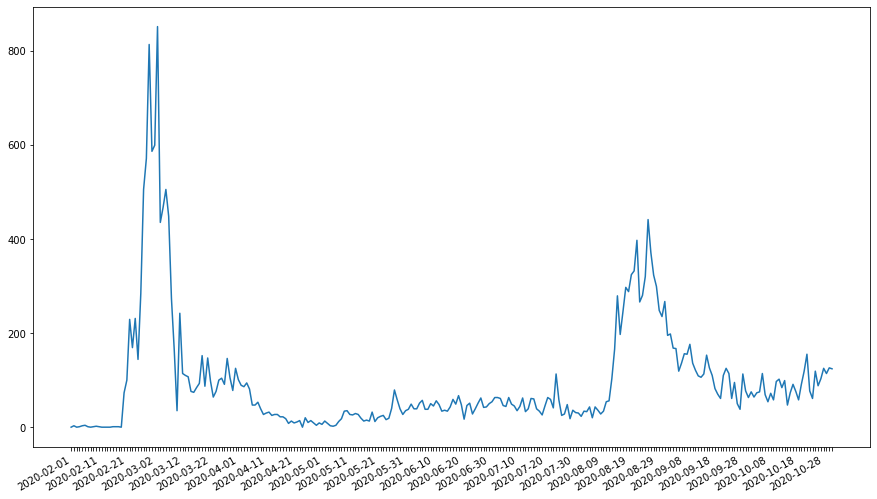

In [30]:
import matplotlib.dates as mdates
dates = daily_increased_df.index.tolist()

y_values = daily_increased_df['daily_increase'].tolist()


plt.rcParams['figure.figsize'] = [15, 9]
fig, ax = plt.subplots()
ax.plot(dates, y_values)


fig.autofmt_xdate()

ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
plt.savefig('Fig2.png')
plt.show()


In [21]:
X = policy_execute_df.values
Y = daily_increased_df.values.transpose()[0]

X_train,X_test,y_train,y_test=train_test_split(X,Y, test_size=0.3, random_state=31)

In [22]:
# LASSO with alpha = 1
lasso = Lasso()
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)

print ("training score:", train_score)
print ("test score: ", test_score)
print ("number of features used: ", coeff_used)
start_date_to_policy = {}
for idx, w in enumerate(lasso.coef_):
    if w != 0:
        policy = idx_to_policy[idx]
        if policy != 'nan':
            print(policy)
            print(policy_to_start_date[policy])



training score: 0.9477010642194577
test score:  0.9058801730277787
number of features used:  25
Infectious Disease Alert Level Level 3 (Orange)
2020-01-28
Emergency Use Authorization of Diagnostic Kit 2nd EUA
2020-02-12
Drive-Through Screening Center by Local Government
2020-02-26
Emergency Use Authorization of Diagnostic Kit 4th EUA
2020-02-27
Emergency Use Authorization of Diagnostic Kit 3rd EUA
2020-02-27
Social Distancing Campaign Strong
2020-04-06
School Opening Delay Kindergarten
2020-03-02
School Opening Delay Middle School
2020-03-02
School Opening Delay High School
2020-03-02
School Opening Delay Elementary School
2020-03-02
Drive-Through Screening Center Standard Operating Procedures
2020-03-04
Open API Public Mask Sales Information
2020-03-08
Special Immigration Procedure from Japan
2020-03-09
Special Immigration Procedure from Italy
2020-03-12
Special Immigration Procedure from Iran
2020-03-12
Emergency Use Authorization of Diagnostic Kit 5th EUA
2020-03-13
Special Immigrat

In [23]:
lasso01 = Lasso(alpha=0.1, max_iter=10e5)
lasso01.fit(X_train,y_train)
train_score01=lasso01.score(X_train,y_train)
test_score01=lasso01.score(X_test,y_test)
coeff_used01 = np.sum(lasso01.coef_!=0)
print ("training score for alpha=0.1:", train_score01)
print ("test score for alpha =0.1: ", test_score01)
print ("number of features used: for alpha =0.1:", coeff_used01)
start_date_to_policy = {}
for idx, w in enumerate(lasso.coef_):
    if w != 0:
        policy = idx_to_policy[idx]
        if policy != 'nan':
            print(policy)
            print(policy_to_start_date[policy])


training score for alpha=0.1: 0.9554327569018448
test score for alpha =0.1:  0.9131001231434592
number of features used: for alpha =0.1: 36
Infectious Disease Alert Level Level 3 (Orange)
2020-01-28
Emergency Use Authorization of Diagnostic Kit 2nd EUA
2020-02-12
Drive-Through Screening Center by Local Government
2020-02-26
Emergency Use Authorization of Diagnostic Kit 4th EUA
2020-02-27
Emergency Use Authorization of Diagnostic Kit 3rd EUA
2020-02-27
Social Distancing Campaign Strong
2020-04-06
School Opening Delay Kindergarten
2020-03-02
School Opening Delay Middle School
2020-03-02
School Opening Delay High School
2020-03-02
School Opening Delay Elementary School
2020-03-02
Drive-Through Screening Center Standard Operating Procedures
2020-03-04
Open API Public Mask Sales Information
2020-03-08
Special Immigration Procedure from Japan
2020-03-09
Special Immigration Procedure from Italy
2020-03-12
Special Immigration Procedure from Iran
2020-03-12
Emergency Use Authorization of Diagno

In [24]:
lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_train,y_train)
train_score001=lasso001.score(X_train,y_train)
test_score001=lasso001.score(X_test,y_test)
coeff_used001 = np.sum(lasso001.coef_!=0)
print ("training score for alpha=0.01:", train_score001)
print ("test score for alpha =0.01: ", test_score001)
print ("number of features used: for alpha =0.01:", coeff_used001)

training score for alpha=0.01: 0.9561953863630702
test score for alpha =0.01:  0.9029729620707928
number of features used: for alpha =0.01: 41


In [26]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr_train_score=lr.score(X_train,y_train)
lr_test_score=lr.score(X_test,y_test)
print ("LR training score:", lr_train_score)
print ("LR test score: ", lr_test_score)

LR training score: 0.9562130173844463
LR test score:  -1.984462116149399e+22
